In [2]:
%load_ext autoreload
%autoreload 2

import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import casadi as cas
import pickle
import copy as cp
import scipy.optimize

import argparse


import src.multiagent_mpc as mpc
import src.traffic_world as tw
import src.utils.plotting.car_plotting as cmplot

np.set_printoptions(precision=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
x_e, y_e = 0,0
r = 1.5

In [5]:
W = 1.8
L = 4.5

n_circles = 3

## Calculate Circles

In [6]:
opti = cas.Opti()
r = opti.variable()
dx = opti.variable()
x_overlap = opti.variable()
opti.minimize(r**2)

opti.subject_to((W/2-0)**2 + (0-0)**2 <= r**2)
opti.subject_to((W/2-0)**2 + (x_overlap-0)**2 <= r**2)
opti.subject_to((W/2-0)**2 + (x_overlap-dx)**2 <= r**2)
opti.subject_to((W/2-0)**2 + (L/2-dx)**2 <= r**2)

opti.subject_to(opti.bounded(0,dx,L/2))
opti.subject_to(r>0)
opti.subject_to(opti.bounded(0,x_overlap, L/2))


# opt.subject_to(opti.bounded(0, x_c1, x_overlap))
# opt.subject_to(opti.bounded(x_overlap, x_c2, x_overlap))

opti.solver('ipopt',{},{'print_level':1})
sol = opti.solve()
r_opt = sol.value(r)
dx_opt = sol.value(dx)
print(r_opt, dx_opt)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  52.00us (  2.08us)  50.63us (  2.03us)        25
       nlp_g  |  99.00us (  3.96us)  95.08us (  3.80us)        25
  nlp_grad_f  |  64.00us (  3.37us)  59.54us (  3.13us)        19
  nlp_hess_l  |  95.00us (  5.59us)  93.87us (  5.52us)        17
   nlp_jac_g  | 128.00us (  6.74us) 128.63us (  6.77us)        19
       total  |   7.99ms (  7.99ms)   7.60ms (  7.60ms)         1
1.1715374503193001 1.5000000000029359


(-3.25, 3.25)

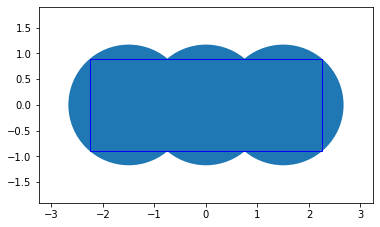

In [7]:
x_e, y_e = 0, 0
plt.plot(x_e, y_e)

c1 = patches.Circle((x_e, y_e), radius=r_opt)
c2 = patches.Circle((x_e+dx_opt, y_e), radius=r_opt)
c3 = patches.Circle((x_e-dx_opt, y_e), radius=r_opt)

ax = plt.gca()
ax.axis('square')
ax.add_patch(c1)
ax.add_patch(c2)
ax.add_patch(c3)
rec = patches.Rectangle((x_e-L/2, y_e-W/2), L, W, fill=None, edgecolor='blue')
ax.add_patch(rec)
ax.set_ylim([-W/2-1, W/2+1])
ax.set_xlim([-L/2-1, L/2+1])

# ax.set_ylim([-10, 10])
# ax.set_xlim([-10, 10])

In [8]:
opti = cas.Opti()
r = opti.parameter()
dx = opti.variable()
x_overlap = opti.variable()
opti.minimize(dx)

# opti.subject_to((W/2-0)**2 + (0-0)**2 <= r**2)
opti.subject_to((W/2-0)**2 + (x_overlap-0)**2 <= r**2)
opti.subject_to((W/2-0)**2 + (x_overlap-dx)**2 <= r**2)
opti.subject_to((W/2-0)**2 + (L/2-dx)**2 <= r**2)

opti.subject_to(opti.bounded(0,dx,L/2))
# opti.subject_to(r>0)
opti.subject_to(opti.bounded(0,x_overlap, L/2))


opti.set_value(r, 1.25*r_opt)

opti.solver('ipopt',{},{'print_level':1})
sol = opti.solve()
r_opt = sol.value(r)
dx_opt = sol.value(dx)
print(r_opt, dx_opt)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  26.00us (  2.89us)  24.29us (  2.70us)         9
       nlp_g  |  50.00us (  5.56us)  47.87us (  5.32us)         9
    nlp_grad  |   7.00us (  7.00us)   6.78us (  6.78us)         1
  nlp_grad_f  |  40.00us (  4.00us)  37.82us (  3.78us)        10
  nlp_hess_l  |  45.00us (  5.63us)  43.94us (  5.49us)         8
   nlp_jac_g  |  61.00us (  6.10us)  62.10us (  6.21us)        10
       total  |   4.46ms (  4.46ms)   4.43ms (  4.43ms)         1
1.464421812899125 1.0947808598616502


(-3.25, 3.25)

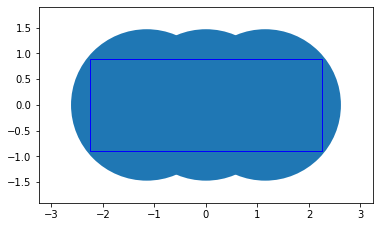

In [9]:
x_e, y_e = 0, 0
plt.plot(x_e, y_e)
r, dx = 1.47, 1.15

c1 = patches.Circle((x_e, y_e), radius=r)
c2 = patches.Circle((x_e+dx, y_e), radius=r)
c3 = patches.Circle((x_e-dx, y_e), radius=r)

ax = plt.gca()
ax.axis('square')
ax.add_patch(c1)
ax.add_patch(c2)
ax.add_patch(c3)
rec = patches.Rectangle((x_e-L/2, y_e-W/2), L, W, fill=None, edgecolor='blue')
ax.add_patch(rec)
ax.set_ylim([-W/2-1, W/2+1])
ax.set_xlim([-L/2-1, L/2+1])

# ax.set_ylim([-10, 10])
# ax.set_xlim([-10, 10])

In [10]:
opti = cas.Opti()
r = opti.variable()
dx = opti.variable()
# x_overlap = opti.variable()
opti.minimize(r**2)

opti.subject_to((W/2-0)**2 + (0-dx)**2 <= r**2)
# opti.subject_to((W/2-0)**2 + (x_overlap-0)**2 <= r**2)
# opti.subject_to((W/2-0)**2 + (x_overlap-dx)**2 <= r**2)
opti.subject_to((W/2-0)**2 + (L/2-dx)**2 <= r**2)

opti.subject_to(opti.bounded(0,dx,L/2))
opti.subject_to(r>0)
# opti.subject_to(opti.bounded(0,x_overlap, L/2))


# opt.subject_to(opti.bounded(0, x_c1, x_overlap))
# opt.subject_to(opti.bounded(x_overlap, x_c2, x_overlap))

opti.solver('ipopt',{},{'print_level':1})
sol = opti.solve()
r_opt = sol.value(r)
dx_opt = sol.value(dx)
print(r_opt, dx_opt)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 129.00us (  2.69us) 124.92us (  2.60us)        48
       nlp_g  | 264.00us (  5.08us) 256.02us (  4.92us)        52
  nlp_grad_f  |  96.00us (  3.84us)  99.22us (  3.97us)        25
  nlp_hess_l  | 154.00us (  5.50us) 156.54us (  5.59us)        28
   nlp_jac_g  | 245.00us (  7.21us) 245.42us (  7.22us)        34
       total  |  18.68ms ( 18.68ms)  18.56ms ( 18.56ms)         1
1.4407029516912184 1.125


(-3.25, 3.25)

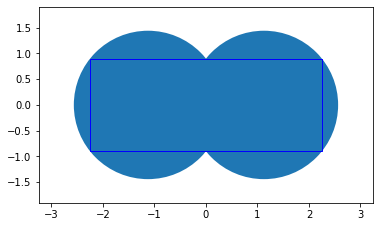

In [11]:
x_e, y_e = 0, 0
plt.plot(x_e, y_e)

c1 = patches.Circle((x_e-dx_opt, y_e), radius=r_opt)
c2 = patches.Circle((x_e+dx_opt, y_e), radius=r_opt)
ax = plt.gca()
ax.axis('square')
ax.add_patch(c1)
ax.add_patch(c2)
# ax.add_patch(c3)
rec = patches.Rectangle((x_e-L/2, y_e-W/2), L, W, fill=None, edgecolor='blue')
ax.add_patch(rec)
ax.set_ylim([-W/2-1, W/2+1])
ax.set_xlim([-L/2-1, L/2+1])

# ax.set_ylim([-10, 10])
# ax.set_xlim([-10, 10])

(-3.25, 3.25)

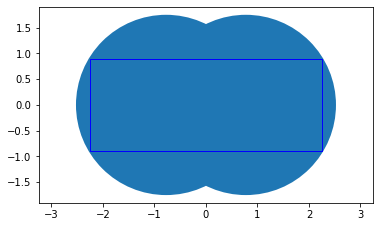

In [33]:
x_e, y_e = 0, 0
plt.plot(x_e, y_e)
r, dx = 1.75, 0.77389
c1 = patches.Circle((x_e-dx, y_e), radius=r)
c2 = patches.Circle((x_e+dx, y_e), radius=r)
ax = plt.gca()
ax.axis('square')
ax.add_patch(c1)
ax.add_patch(c2)
# ax.add_patch(c3)
rec = patches.Rectangle((x_e-L/2, y_e-W/2), L, W, fill=None, edgecolor='blue')
ax.add_patch(rec)
ax.set_ylim([-W/2-1, W/2+1])
ax.set_xlim([-L/2-1, L/2+1])

# ax.set_ylim([-10, 10])
# ax.set_xlim([-10, 10])

## Calculate the Ellipse Obstacle

In [14]:
def get_ellipse(L, W):
    min_elipse_a =  lambda a: (1 - L**2/(2*a)**2 - W**2/(2*a + W - L)**2)
    
    ax = scipy.optimize.fsolve(min_elipse_a, L/2.0)
    by = ax + .5*(W-L)
    return ax, by

In [25]:
a, b = get_ellipse(L, W)

## Draw Ellipse

In [92]:
a, b = get_ellipse(L, W)

opti = cas.Opti()
r = opti.variable()
dx = opti.variable()
opti.minimize(r**2 + dx**2)

# opti.subject_to(r>=a)
# opti.subject_to(r>=b)
opti.subject_to(dx>=0)
# opti.subject_to(opti.bounded(0,dx,b))

costheta = opti.variable()
sintheta = opti.variable()
opti.subject_to(costheta == a*dx/(a**2-b**2))
opti.subject_to(costheta**2 + sintheta**2 == 1)


# opti.subject_to(a**2 * costheta**2 - 2*a*costheta*dx + dx**2 + b**2*sintheta**2 <= r**2)
opti.subject_to(dx**2 + b**2 <=r**2)

opti.subject_to((a-dx)**2 <= r**2)

# opti.subject_to(opti.bounded(0,dx,L/2))
# opti.subject_to(r>0)
# opti.subject_to(opti.bounded(0,x_overlap, L/2))


# opt.subject_to(opti.bounded(0, x_c1, x_overlap))
# opt.subject_to(opti.bounded(x_overlap, x_c2, x_overlap))

opti.solver('ipopt',{},{'print_level':1})
opti.set_initial(r, W/2.0)
opti.set_initial(dx, 0)
sol = opti.solve()
r_opt = sol.value(r)
dx_opt = sol.value(dx)
print(r_opt, dx_opt)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 236.00us (  4.14us) 233.12us (  4.09us)        57
       nlp_g  | 505.00us (  8.86us) 495.21us (  8.69us)        57
  nlp_grad_f  | 246.00us (  6.15us) 243.09us (  6.08us)        40
  nlp_hess_l  | 298.00us (  7.64us) 299.32us (  7.67us)        39
   nlp_jac_g  | 498.00us ( 10.60us) 497.42us ( 10.58us)        47
       total  |  40.29ms ( 40.29ms)  40.10ms ( 40.10ms)         1
2.5348413508498657 2.0564654362975143


In [93]:
(0,b), (dx,0)
b**2 + dx_opt**2

array([6.43])

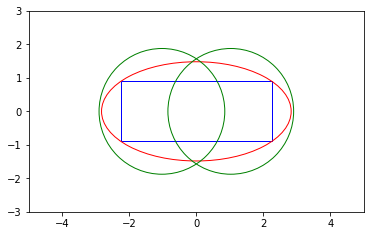

In [113]:
plt.plot(x_e, y_e)
ax = plt.gca()
ax.axis('square')
plt.xlim([-5, 5])
plt.ylim([-3, 3])

W = 1.8
L = 4.5
x_o, y_o = 0, 0
rec = patches.Rectangle((x_e-L/2, x_e-W/2), L, W, fill=None, edgecolor='blue')
ax.add_patch(rec)
e = patches.Ellipse((x_e, x_e), 2*a, 2*b, fill=False, edgecolor='red')
ax.add_patch(e)


e1 = patches.Circle((x_e+dx_opt/2, y_e), r_opt/1.35, fill=False, edgecolor='green')
e2 = patches.Circle((x_e-dx_opt/2, y_e), r_opt/1.35, fill=False, edgecolor='green')

ax.add_patch(e1)
ax.add_patch(e2)

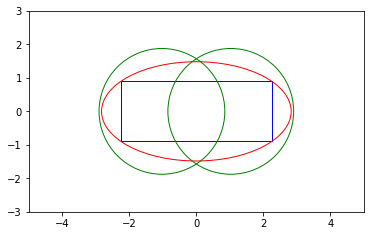

In [117]:
plt.plot(x_e, y_e)
ax = plt.gca()
ax.axis('square')
plt.xlim([-5, 5])
plt.ylim([-3, 3])

W = 1.8
L = 4.5
x_o, y_o = 0, 0
rec = patches.Rectangle((x_e-L/2, x_e-W/2), L, W, fill=None, edgecolor='blue')
ax.add_patch(rec)
e = patches.Ellipse((x_e, x_e), 2*a, 2*b, fill=False, edgecolor='red')
ax.add_patch(e)

dx = 1.028
r = 1.878
e1 = patches.Circle((x_e+dx, y_e), r, fill=False, edgecolor='green')
e2 = patches.Circle((x_e-dx, y_e), r, fill=False, edgecolor='green')

ax.add_patch(e1)
ax.add_patch(e2)

In [114]:
dx_opt, r_opt

(2.0564654362975143, 2.5348413508498657)

In [116]:
r_opt/1.35

1.8776602598887893

# 

In [16]:
def get_collision_ellipse(r, L, W):
    a, b = get_ellipse(L, W)
    minimal_positive_root = lambda delta: (2*(delta + r)**2*(2*a*b + a*(delta + r) + b*(delta + r)))/((a + b)*(a + b + 2*delta + 2*r))-r**2
    delta = scipy.optimize.fsolve(minimal_positive_root, r)
    a_new = a+delta+r
    b_new = b+delta+r
    return a_new, b_new, delta, a, b

In [17]:
x_o, y_o = 4,0
phi_o = 0.0 * np.pi/180

In [18]:
dx = x_o - x_e
dy = y_o - y_o

In [19]:
alpha = 4.3767
beta = 3.0267

In [20]:
def R(phi):
    return np.array([[np.cos(phi), 0],[0, np.sin(phi)]])

In [21]:
R_o = R(phi_o)

In [22]:
collision_free = (np.array([[dx],[dy]]).T @ R_o.T @ np.array([[1/alpha**2, 0],[0, 1/beta**2]]) @ R_o @ np.array([[dx],[dy]])) > 1

In [23]:
collision_free

array([[False]])

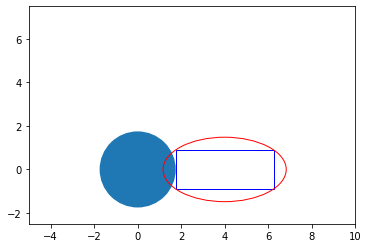

In [24]:
plt.plot(x_e, y_e)
c = patches.Circle((x_e, y_e), radius=r)
ax = plt.gca()
ax.axis('square')
ax.add_patch(c)
plt.xlim([-5, 10])
plt.ylim([-2.5, 7.5])

plt.plot(x_o, y_o)
a = 2.832
b = 1.4820


# a_val = 4.5
# b_val = 1.8
W = 1.8
L = 4.5
rec = patches.Rectangle((x_o-L/2, y_o-W/2), L, W, fill=None, edgecolor='blue')
ax.add_patch(rec)
a_val = 2.832
b_val = 1.4820
# a_val, b_val = 3.897114298575689, 1.1022703788869466
e = patches.Ellipse((x_o, y_o), 2*a_val, 2*b_val, fill=False, edgecolor='red')
ax.add_patch(e)

[[False]]


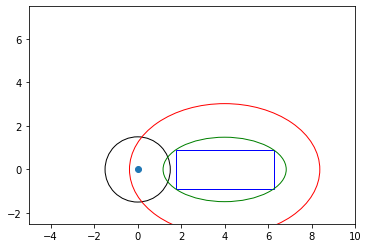

In [13]:
### Another way to see it as following
plt.plot(x_e, y_e,'o')
c = patches.Circle((x_e, y_e), radius=r, fill=None)
ax = plt.gca()
ax.axis('square')
ax.add_patch(c)
plt.xlim([-5, 10])
plt.ylim([-2.5, 7.5])

plt.plot(x_o, y_o)
a = 2.832
b = 1.4820


# a_val = 4.5
# b_val = 1.8
W = 1.8
L = 4.5
rec = patches.Rectangle((x_o-L/2, y_o-W/2), L, W, fill=None, edgecolor='blue')
ax.add_patch(rec)
a_val = 2.832
b_val = 1.4820

delta = 0.0447


# a_val, b_val = 3.897114298575689, 1.1022703788869466
e = patches.Ellipse((x_o, y_o), 2*(a_val), 2*(b_val), fill=False, edgecolor='green')
e_b = patches.Ellipse((x_o, y_o), 2*(a_val+delta+r), 2*(b_val+delta+r), fill=False, edgecolor='red')
ax.add_patch(e)
ax.add_patch(e_b)

collision_free = (np.array([[dx],[dy]]).T @ R_o.T @ np.array([[1/alpha**2, 0],[0, 1/beta**2]]) @ R_o @ np.array([[dx],[dy]])) > 1
print(collision_free)

array([[4.0, 0],
       [0, array([0.])]], dtype=object)

In [96]:
import casadi as cas

In [153]:
opti = cas.Opti()
a = opti.variable()
b = opti.variable()
opti.minimize(a*b**2)
opti.subject_to( ((L/2)**2/a**2 + (W/2)**2/b**2) <= 1)
opti.subject_to(a>0)
opti.subject_to(b>0)
opti.solver('ipopt')

In [154]:
opti.set_initial(a, 1)
opti.set_initial(b, 1.5)
solution = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [157]:
a_val = solution.value(a)
b_val = solution.value(b)
print(a_val, b_val)

3.897114298575689 1.1022703788869466


In [156]:
(L/2)**2/a_val**2 + (W/2)**2/b_val**2

1.0000000096471355

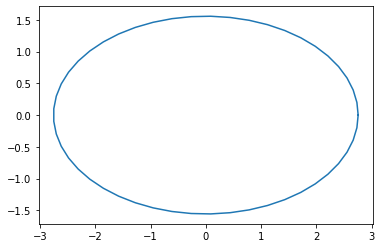

In [152]:
plt.plot([a_val*np.cos(t) for t in np.linspace(0, 2*np.pi, 50)], [b_val*np.sin(t) for t in np.linspace(0, 2*np.pi, 50)])

## From MATLAB

In [ ]:
clear all 
close all
clc 

%% 
W = 1.8;
L = 4.5;

min_elipse_box = @(a) (1 - L^2/(2*a)^2 - W^2/(2*a + W - L)^2) ;
a = fzero(min_elipse_box, 10)
b = a + 1/2*(W-L)
t = 0:.1:2*pi;
x = a*cos(t);
y = b*sin(t);
plot(x,y)
rectangle('Position',[-L/2 -W/2 L W])
axis('equal')
hold on
 
%% ellipsoid and circle dimensions
%a = 10; 
%b = 2; 
r = 1.5;
 
M = 400; 
dtheta = 2*pi / M; 
theta_M = (0 : dtheta : 2*pi)'; 


minimal_positive_root = @(delta) (2*(delta + r)^2*(2*a*b + a*(delta + r) + b*(delta + r)))/((a + b)*(a + b + 2*delta + 2*r))-r^2; 
x0 = 1.5; % initial guess must be always positive
delta = fzero(minimal_positive_root,x0)
disp(delta)
a_new = a+delta+r
b_new = b+delta+r

x = a_new*cos(t);
y = b_new*sin(t);
plot(x,y)

%%

for i = 1 : M+1 
    theta = theta_M(i); 
    
    %% ellipse coordinates
    x_M(i) = a * cos(theta); 
    y_M(i) = b * sin(theta); 
     
    alpha = a+delta+r; 
    beta = b+delta+r; 

    %% bounding ellipse
    
    x_1_M(i) = alpha * cos(theta); 
    y_1_M(i) = beta * sin(theta); 
    
    %% Minkowsky sum of ellipse (a,b) and circle r
    x_2_M(i) = a*cos(theta) + r*cos(theta)/(sqrt((cos(theta))^2 + (a^2/b^2)*(sin(theta))^2)); 
    y_2_M(i) = b*sin(theta) + r*sin(theta)/(sqrt((b^2/a^2)*(cos(theta))^2 + (sin(theta))^2));    
     

    %% previously used bounding ellipse
    a_3 = a + r; 
    b_3 = b + r; 
    x_3_M(i) = a_3 * cos(theta); 
    y_3_M(i) = b_3 * sin(theta); 
     
    %% circle coordinates
    x_4_M(i) = r * cos(theta); 
    y_4_M(i) = r * sin(theta); 
end 

h=figure; 
hold all; 
box on; 
grid on; 
axis equal; 
plot(x_M, y_M, '-r') 

plot(x_1_M, y_1_M, '-k') 
plot(x_2_M, y_2_M, '-b') 
plot(x_3_M, y_3_M, '-r')
legend("Ellipse","Minimal Bounding ellipse","Minkowski Sum","Bound Ellipse + Circle","Circle")
% legend(h,'off')
plot(x_4_M, y_4_M, '-g') 
% circle(0,0,a+r)


K = randi([floor(M/4/4), ceil(M/4/2)]); 
theta = theta_M(K); 
x = a * cos(theta); 
y = b * sin(theta); 
plot([0,x], [0, y], '-k') 
normal = r*[2*cos(theta)/a; 2*sin(theta)/b] / norm([2*cos(theta)/a; 2*sin(theta)/b]); 
plot([0, normal(1)], [0, normal(2)], '-b') 
plot([x, normal(1)+x], [y, normal(2)+y], '-b')
circle(normal(1)+x, normal(2)+y, r)
hold all
 
% theta_T = theta_M(1 : ceil(M/2)+1); 
% theta_T = theta_M; 
% delta_x_T = cos(theta_T) .* (r ./ (sqrt((cos(theta_T)).^2 + (a^2/b^2)*(sin(theta_T)).^2)) - 1); 
% delta_y_T = sin(theta_T) .* (r ./ (sqrt((b^2/a^2)*(cos(theta_T)).^2 + (sin(theta_T)).^2)) - 1); 
% figure; 
% hold all; 
% grid on; 
% box on; 
% plot(delta_x_T, '-k'); 
% plot(delta_y_T, '-r'); 
%  
% delta_a_T = r ./ (sqrt((cos(theta_T)).^2 + (a^2/b^2)*(sin(theta_T)).^2)); 
% delta_b_T = r ./ (sqrt((b^2/a^2)*(cos(theta_T)).^2 + (sin(theta_T)).^2)); 
% figure; 
% hold all; 
% grid on; 
% box on; 
% plot(delta_a_T, '-k'); 
% plot(delta_b_T, '-r'); 

%%Curvature calculation
% k=a*b/(sqrt(a^2/2+b^2/2)^3)
% k_r=(a+r)*(b+r)/(sqrt((a+r)^2/2+(b+r)^2/2)^3)
% t=0:0.01:2*pi
% figure;
% plot(t,a.*b./(sqrt(a.^2.*cos(t).^2+b.^2.*sin(t).^2).^3))
% hold on;
% ar=a+r;
% br=b+r;
% plot(t,ar.*br./(sqrt(ar.^2.*cos(t).^2+br.^2.*sin(t).^2).^3),'b')
% figure;
% plot(t,a^2.*cos(t).^2+b^2.*sin(t).^2)

function h = circle(x,y,r)
    hold on
    th = 0:pi/50:2*pi;
    xunit = r * cos(th) + x;
    yunit = r * sin(th) + y;
    h = plot(xunit, yunit);
%     hold off
end



